# **Импорты**

Общие модули, которые будут использованы для анализа данных

In [ ]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import seaborn as sns
import statistics as stats
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

Модули библиотеки PySpark, служащие для взаимодействия с движком Spark. Настройка Spark и запуск сессии

In [ ]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

MAX_MEMORY = '15G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()

DataFrame[tweetid: bigint, userid: string, user_display_name: string, user_reported_location: string, follower_count: string, following_count: string, account_creation_date: timestamp, account_language: string, tweet_language: string]

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


# **Подготовка данных**

Чтение датасета из файла

In [ ]:
filename_data = '/content/iranian_tweets_csv_hashed.csv'
df = spark.read.option("escapeQuotes", "true").csv(filename_data, header=True, inferSchema=True)

Схема датафрейма



In [ ]:
print('Data overview')
df.printSchema()
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Data overview
root
 |-- tweetid: long (nullable = true)
 |-- userid: string (nullable = true)
 |-- user_display_name: string (nullable = true)
 |-- user_screen_name: string (nullable = true)
 |-- user_reported_location: string (nullable = true)
 |-- user_profile_description: string (nullable = true)
 |-- user_profile_url: string (nullable = true)
 |-- follower_count: string (nullable = true)
 |-- following_count: string (nullable = true)
 |-- account_creation_date: timestamp (nullable = true)
 |-- account_language: string (nullable = true)
 |-- tweet_language: string (nullable = true)
 |-- tweet_text: string (nullable = true)
 |-- tweet_time: string (nullable = true)
 |-- tweet_client_name: string (nullable = true)
 |-- in_reply_to_tweetid: string (nullable = true)
 |-- in_reply_to_userid: string (nullable = true)
 |-- quoted_tweet_tweetid: string (nullable = true)
 |-- is_retweet: string (nullable = true)
 |-- retweet_userid: string (nullable = true)
 |-- retweet_tweetid: string (null

,Column Name,Data type
0,tweetid,bigint
1,userid,string
2,user_display_name,string
3,user_screen_name,string
4,user_reported_location,string
5,user_profile_description,string
6,user_profile_url,string
7,follower_count,string
8,following_count,string
9,account_creation_date,timestamp


Датасет состоит из следующих столбцов:

1.	tweetid	– id твита
2.	userid – id пользователя
3.	user_display_name – отображаемое имя пользователя
4.	user_screen_name – имя пользователя
5.	user_reported_location – местоположение сообщённое пользователем
6.	user_profile_description - описание профиля пользователя
7.	user_profile_url - URL-адрес профиля пользователя
8.	follower_count - количество подписчиков
9.	following_count - количество подписок
10.	account_creation_date - дата создания учетной записи
11.	account_language - язык аккаунта
12.	tweet_language - язык твита
13.	tweet_text - текст твита
14.	tweet_time - время твита
15.	tweet_client_name - имя клиента твита
16.	in_reply_to_tweetid – id твита на который ответили
17.	in_reply_to_userid – id пользователя на чей твит ответили
18.	quoted_tweet_tweetid – id цитируемого твита
19.	is_retweet – это ритвит
20.	retweet_userid - id пользователя который ретвитнул
21.	retweet_tweetid - id твита который ритвитнули
22.	latitude - широта
23.	longitude - долгота
24.	quote_count - количество цитат
25.	reply_count - количество ответов
26.	like_count – количество лайков
27.	retweet_count – количество ретвитов
28.	hashtags - хэштеги
29.	urls - URL
30.	user_mentions - пользователь упоминает
31.	poll_choices - варианты опроса


Большинство этой информации для анализа бесполезна, оставим только следующие столбцы:
1.	tweetid	– id твита
2.	userid – id пользователя
3.	user_display_name – отображаемое имя пользователя
4.	user_reported_location – местоположение сообщённое пользователем
5.	follower_count - количество подписчиков
6.	following_count - количество подписок
7.	account_creation_date - дата создания учетной записи
8.	account_language - язык аккаунта
9.	tweet_language - язык твита


In [ ]:
df = df['tweetid', 'userid', 'user_display_name', 'user_reported_location', 'follower_count', 'following_count', 'account_creation_date', 'account_language', 'tweet_language']
df.limit(5).toPandas()

,tweetid,userid,user_display_name,user_reported_location,follower_count,following_count,account_creation_date,account_language,tweet_language
0,533622371429543936,299148448,Maria Luis,"Nantes, France",8012,1450,2011-05-15,en,fr
1,527205814906654721,299148448,Maria Luis,"Nantes, France",8012,1450,2011-05-15,en,en
2,545166827350134784,299148448,Maria Luis,"Nantes, France",8012,1450,2011-05-15,en,en
3,538045437316321280,299148448,Maria Luis,"Nantes, France",8012,1450,2011-05-15,en,fr
4,530053681668841472,299148448,Maria Luis,"Nantes, France",8012,1450,2011-05-15,en,fr


Проверим наличие пропущенных значений в датасете



In [ ]:
df.select([f.count(f.when(f.isnan(c)|f.col(c).isNull(), c)).alias(c) for c, t in df.dtypes if t != "timestamp"]).toPandas()
# Вывод количества строк до удаления пустых значений
df.count()

,tweetid,userid,user_display_name,user_reported_location,follower_count,following_count,account_language,tweet_language
0,0,0,0,13787,210,0,0,315


63932

Удалим строки с пропущенными значениями

In [ ]:
df = df.dropna()

Проверим наличие пропущенных значений в датасет после удаления

In [ ]:
df.select([f.count(f.when(f.isnan(c)|f.col(c).isNull(), c)).alias(c) for c, t in df.dtypes if t != "timestamp"]).toPandas()
# Вывод количества строк после удаления пустых значений
df.count()

,tweetid,userid,user_display_name,user_reported_location,follower_count,following_count,account_language,tweet_language
0,0,0,0,0,0,0,0,0


49782

Преобразуем столбцы follower_count, following_count в числа

In [ ]:
df = df.withColumn('follower_count', col('follower_count').cast('int'))
df = df.withColumn('following_count', col('following_count').cast('int'))

Описательные характеристики для каждой из колонок

In [ ]:
df.describe().toPandas()

,summary,tweetid,userid,user_display_name,user_reported_location,follower_count,following_count,account_language,tweet_language
0,count,49782,49782,49782,49782,49782,49782,49782,49782
1,mean,7.2221498902021453E17,1.61704952087119744E17,None,None,6270.447792374754,3211.6421799043833,None,None
2,stddev,1.90602330039832032E17,3.2353882273935827E17,None,None,7081.6713042286965,5286.849930706794,None,None
3,min,189682074830114816,0155a9f0201d511948db5a74a672e18d9a00e256031483...,0155a9f0201d511948db5a74a672e18d9a00e256031483...,#Damascus_Syria,0,0,ar,ar
4,max,1032395981973741568,ffe69f2feb6a618093ecd316a64638c76a4ca8b38bdc6f...,🇵🇸Ho3ein🇮🇷,日本 東京,41489,29070,tr,vi


follower_count: среднее значение около 6270.44, со стандартным отклонением около 7081.67. Минимальное значение 0, а максимальное - 41489. Здесь возможны выбросы.

following_count: среднее значение около 3211.64, со стандартным отклонением около 5286.84. Минимальное значение 0, а максимальное - 29070. Здесь возможны выбросы.

Удалим выбросы используя межквартильное расстояние

In [ ]:
def remove_outliers(df, column):
    q1, q3 = df.approxQuantile(column, [0.25, 0.75], 0.05)
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    return df.where((col(column) >= low) & (col(column) <= high))

df = remove_outliers(df, "follower_count")
df = remove_outliers(df, "following_count")
df.describe().toPandas()

,summary,tweetid,userid,user_display_name,user_reported_location,follower_count,following_count,account_language,tweet_language
0,count,39226,39226,39226,39226,39226,39226,39226,39226
1,mean,6.8813967898342246E17,5.1753138305135208E16,None,None,3941.3904808035486,1093.2281394993117,None,None
2,stddev,1.84894186953831552E17,1.9547112340572976E17,None,None,3624.414887022424,702.1221945073926,None,None
3,min,189682074830114816,0155a9f0201d511948db5a74a672e18d9a00e256031483...,0155a9f0201d511948db5a74a672e18d9a00e256031483...,#Damascus_Syria,0,0,ar,ar
4,max,1032366733431005189,ffe69f2feb6a618093ecd316a64638c76a4ca8b38bdc6f...,🇵🇸Ho3ein🇮🇷,日本 東京,15177,3118,tr,vi


# **Визуализацией распределения наиболее важных признаков**

# Построение ящиков с усами

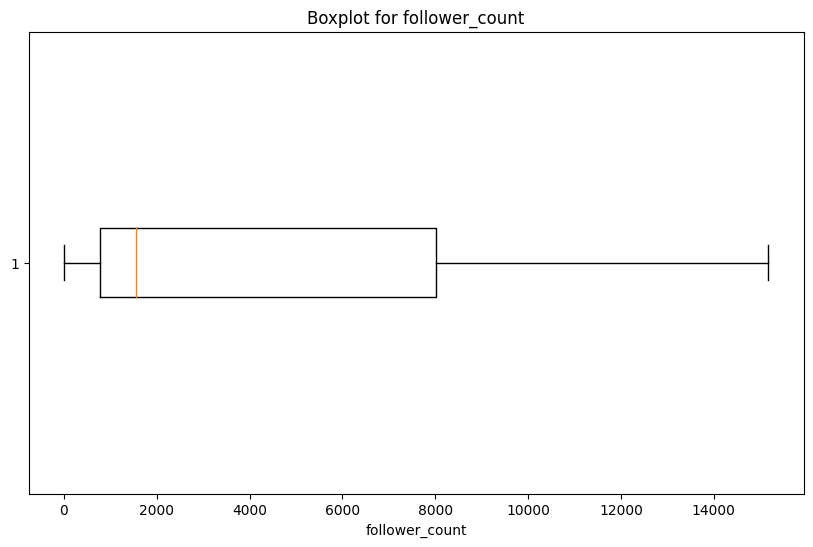

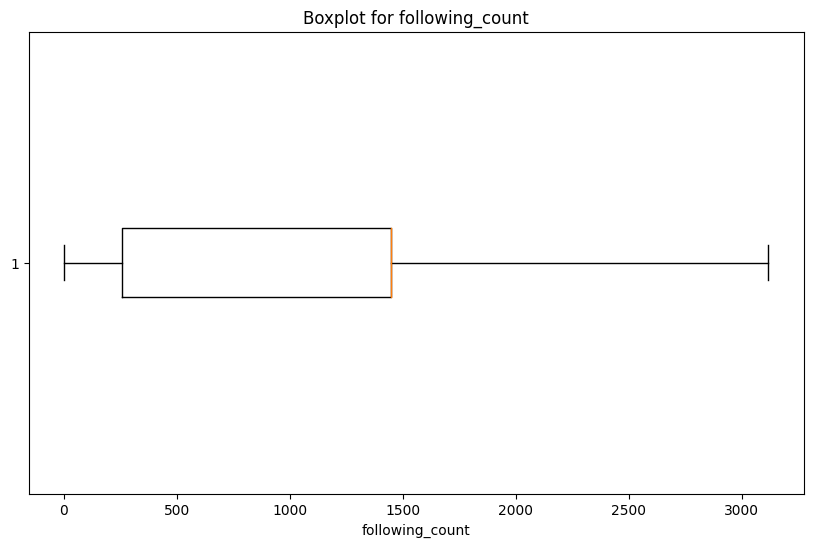

In [ ]:
def create_boxplot(dataframe, column_name, figsize=(10, 6)):
    # столбец из DataFrame
    column = dataframe.select(column_name)

    # столбец в Pandas DataFrame
    pandas_df = column.toPandas()

    # boxplot
    plt.figure(figsize=figsize)
    plt.boxplot(pandas_df[column_name], vert=False)
    plt.title(f"Boxplot for {column_name}")
    plt.xlabel(column_name)
    plt.show()

create_boxplot(df, 'follower_count')
create_boxplot(df, 'following_count')

# Построение гистограмм

<Figure size 1000x600 with 0 Axes>

<Axes: ylabel='Frequency'>

Text(0.5, 1.0, 'Histogram for follower_count')

Text(0.5, 0, 'follower_count')

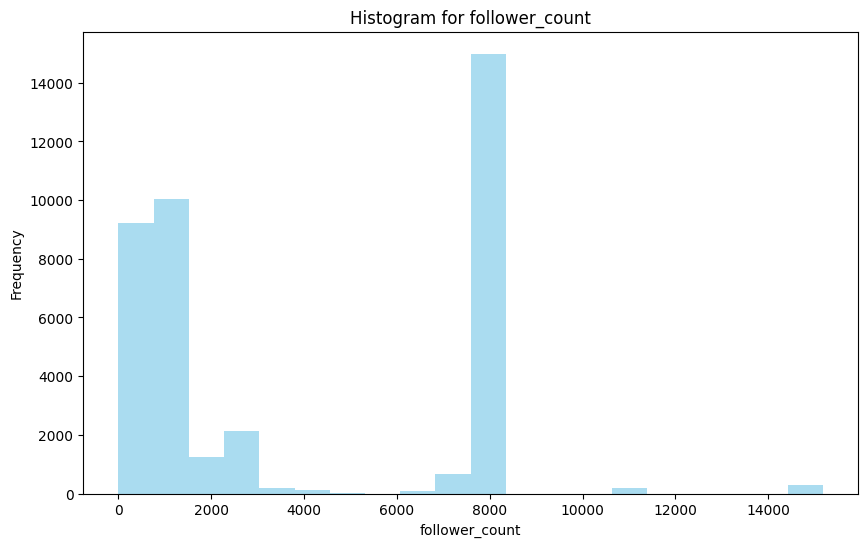

<Figure size 1000x600 with 0 Axes>

<Axes: ylabel='Frequency'>

Text(0.5, 1.0, 'Histogram for following_count')

Text(0.5, 0, 'following_count')

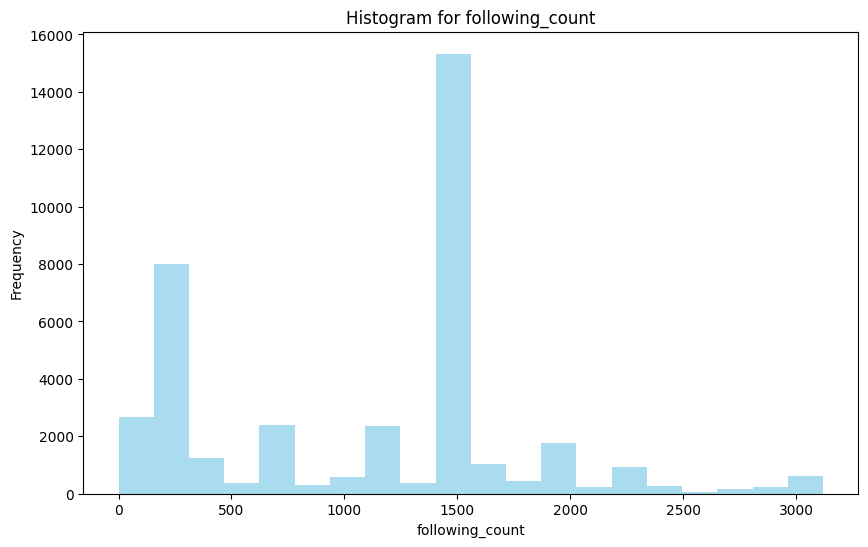

In [ ]:
numeric_columns = ['follower_count', 'following_count']

# гистограммы с использованием matplotlib
for column_name in numeric_columns:
    plt.figure(figsize=(10, 6))
    df.select(column_name).toPandas()[column_name].plot(kind='hist', bins=20, color="skyblue", alpha=0.7)
    plt.title(f"Histogram for {column_name}")
    plt.xlabel(column_name)
    plt.show()

# Построение круговых диаграмм

<Figure size 1000x600 with 0 Axes>

([<matplotlib.patches.Wedge at 0x792a0afe2140>,
 [Text(0.5913742290754462, -0.9275109277983854, 'en'),
  Text(-0.2939042572722234, 1.0600095695592862, 'en-gb'),
  Text(-0.3329159470144738, 1.048411642544786, 'tr'),
  Text(-0.4049363343546855, 1.0227544011733172, 'es'),
  Text(-0.5519402039008775, 0.9515051294227782, 'ar'),
  Text(-0.6761904731809184, 0.8676211408093776, 'fa'),
  Text(-0.7747347392294719, 0.7808880097882426, 'fr')],
 [Text(0.32256776131387976, -0.505915051526392, '90.3%'),
  Text(-0.16031141305757637, 0.5781870379414287, '0.3%'),
  Text(-0.18159051655334935, 0.5718608959335196, '0.9%'),
  Text(-0.2208743641934648, 0.5578660370036275, '1.3%'),
  Text(-0.30105829303684223, 0.5190027978669699, '3.4%'),
  Text(-0.36883116718959186, 0.47324789498693315, '0.9%'),
  Text(-0.42258258503425733, 0.42593891442995047, '2.9%')])

Text(0.5, 1.0, 'Pie Chart for account_language')

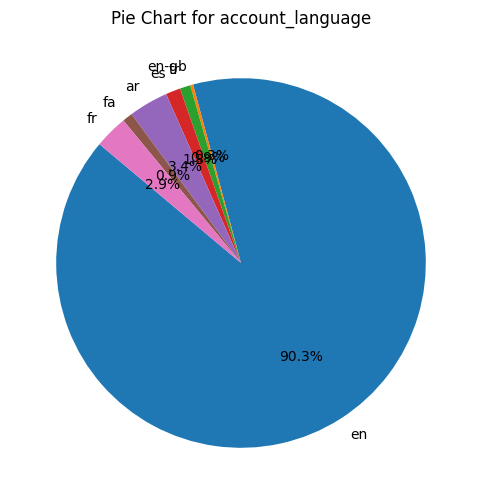

<Figure size 1000x600 with 0 Axes>

([<matplotlib.patches.Wedge at 0x792a09334760>,
 [Text(-1.0996612307906548, 0.027297939409090033, 'en'),
  Text(-0.8762146240977166, -0.6650172422706779, 'vi'),
  Text(-0.8662112385004279, -0.6779956417968739, 'ps'),
  Text(-0.843767811280044, -0.7057307423144357, 'ro'),
  Text(-0.8303943467412503, -0.7214188997386833, 'sl'),
  Text(-0.7638903917592554, -0.7914995068715402, 'und'),
  Text(-0.6913566677914361, -0.8555851552594411, 'ur'),
  Text(-0.6906712118558674, -0.8561385852264503, 'pl'),
  Text(-0.6904654886663486, -0.8563045071472768, 'sk'),
  Text(-0.6888869540817559, -0.8575749322921938, 'pt'),
  Text(-0.6867556665109635, -0.859282639481959, 'tl'),
  Text(-0.6845511876338941, -0.8610398780016087, 'in'),
  Text(-0.6818584011910855, -0.8631738647139039, 'uk'),
  Text(-0.5984714804416357, -0.9229473912948654, 'tr'),
  Text(-0.5087069200971912, -0.9753036806273367, 'de'),
  Text(-0.5062056799120708, -0.9766042236365551, 'sd'),
  Text(-0.30913556845771534, -1.0556681298184223, 'es'),

Text(0.5, 1.0, 'Pie Chart for tweet_language')

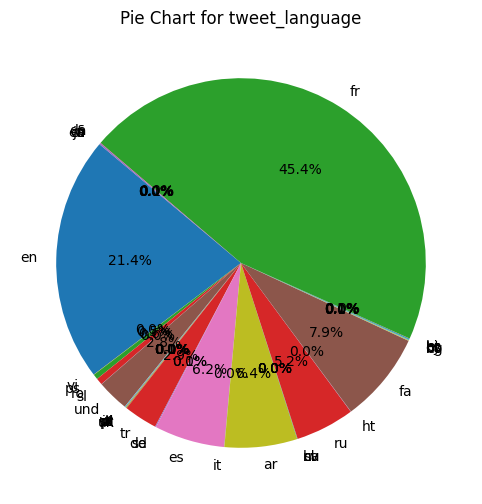

In [ ]:
categorical_columns = ['account_language', 'tweet_language']

# круговые диаграммы с использованием matplotlib
for column_name in categorical_columns:
    counts = df.groupBy(column_name).count().toPandas()

    plt.figure(figsize=(10, 6))
    plt.pie(counts['count'], labels=counts[column_name], autopct='%1.1f%%', startangle=140)
    plt.title(f"Pie Chart for {column_name}")
    plt.show()

# Матрица корреляций между признаками

Преобразум account_language, tweet_language и user_reported_location в числа

In [ ]:
def str_to_index(df, coll_name):
  # StringIndexer для преобразования столбцов в числовые индексы
  indexer = StringIndexer(inputCol=coll_name, outputCol=coll_name+'_index')
  df = indexer.fit(df).transform(df)
  df = df.drop(coll_name)
  return df

df = str_to_index(df, 'account_language')
df = str_to_index(df, 'tweet_language')
df = str_to_index(df, 'user_reported_location')

<Figure size 1000x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Matrix Heatmap')

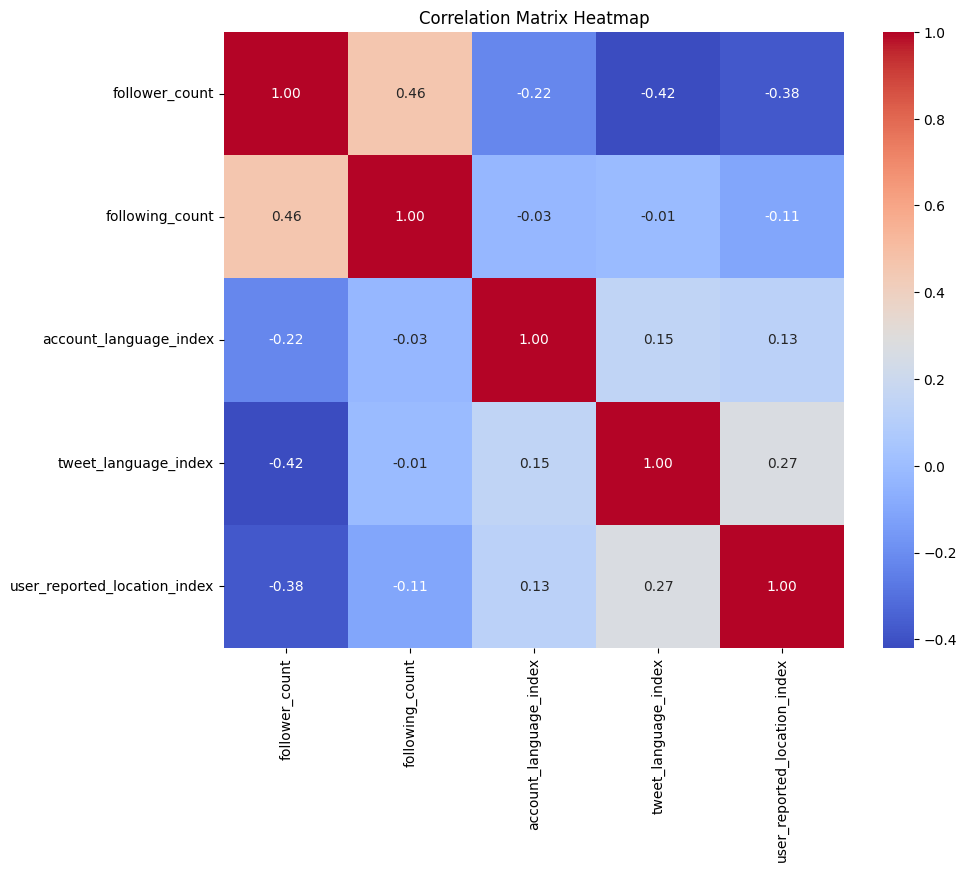

In [ ]:
# нахождение матрицы
numeric_columns = ['follower_count', 'following_count', 'account_language_index', 'tweet_language_index', 'user_reported_location_index']
assembler = VectorAssembler(inputCols=numeric_columns, outputCol="features")
assembled_df = assembler.transform(df).select("features")
correlation_matrix = Correlation.corr(assembled_df, "features").head()
corr_matrix = pd.DataFrame(correlation_matrix[0].toArray(), columns=numeric_columns, index=numeric_columns)

# построение тепловой карты с использованием seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()